# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# pd.options.display.max_rows = 300

In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
s = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Signal 

In [4]:
def band_filter(series):
  return series.applymap(lambda x: -x if abs(x) > 1.5 else 0)

def hold_until_flip(series):
  ser = pd.DataFrame(series)
  ser.columns = ["ccy"]
  ser["shift"] = ser.shift(1)
  ser["sign_change"] = ser.apply(lambda row: 1 if abs(row["ccy"]) > 1.5 else 0, axis=1)
  ser["sign_change"] = ser.apply(lambda row: 1 if row["sign_change"] == 1 else np.nan if pd.isna(row["ccy"]) else 4 if np.sign(row["ccy"]) != np.sign(row["shift"]) else 0 , axis=1)
  ser["signal"] = ser[["ccy"]].pipe(band_filter)
  ser['sign_forward']=ser['sign_change'].replace(0, np.NaN).ffill()
  ser['sign_shift'] = ser['sign_forward'].diff().replace(0, np.NaN)
  ser["signal"] = ser.apply(lambda row: np.nan if pd.isna(row["sign_shift"]) else row["signal"], axis=1).ffill()
  
  return ser["signal"]

In [7]:
sig = spot_returns[universe].fillna(0).pipe(omit_leading_zeros).pipe(zscore, 252*5, 252*3).apply(hold_until_flip)

In [8]:
sig = sig.pipe(demean_xs)
sig[abs(sig) < 0.25] = 0
sig = CAP(sig, 2.5)

In [9]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = s)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [10]:
bt_obj = b

In [11]:
get_summary(bt_obj)

Returns   : -0.016548795104643528
Vol       : 0.11854192054170538
SR        : -0.13960289346604043
Max DD    : -44.71
Hit rate  : 0.503
W | N | L : 0.32 | 0.37 | 0.31
W/L Ratio : 1.01


In [12]:
get_returns_stats(bt_obj.asset_rtn, b.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,-0.366303,-1.080783,-0.01267,-0.750623,-0.064797,-1.195926,0.351644,0.529308,1.268858
sharpe,-0.099694,-0.237117,-0.004353,-0.199963,-0.013708,-0.299325,0.115955,0.146974,0.380977
dollar_sharpe,-0.112768,-0.253369,-0.019278,-0.219452,-0.039596,-0.308773,0.098078,0.12745,0.363785
trade_sharpe,-0.046491,-0.776068,-0.117711,-0.528255,-0.529994,-0.568617,-0.354066,-0.21593,0.350894
long_sharpe,0.776442,-1.250383,-0.191187,-0.887239,-0.519635,0.228391,-0.393584,0.406384,0.688251
short_sharpe,-0.617528,-0.763393,-0.107583,-0.496389,-0.825472,-1.302665,-0.513219,-0.834711,0.187084
sortino,-0.033446,-0.081401,-0.00142,-0.065314,-0.00462,-0.094051,0.038857,0.051443,0.117052
max_drawdown,-30.442435,-22.97319,-14.138304,-21.785485,-18.081212,-33.328081,-8.672704,-9.012016,-7.343108
max_drawdown_start,2004-10-06,2007-09-12,2008-10-10,2003-11-14,2003-07-25,2004-04-27,2011-07-13,2005-02-09,2011-03-22
max_drawdown_end,2008-10-10,2016-03-10,2011-06-13,2014-09-08,2012-11-21,2015-01-30,2016-08-01,2008-09-16,2011-08-09


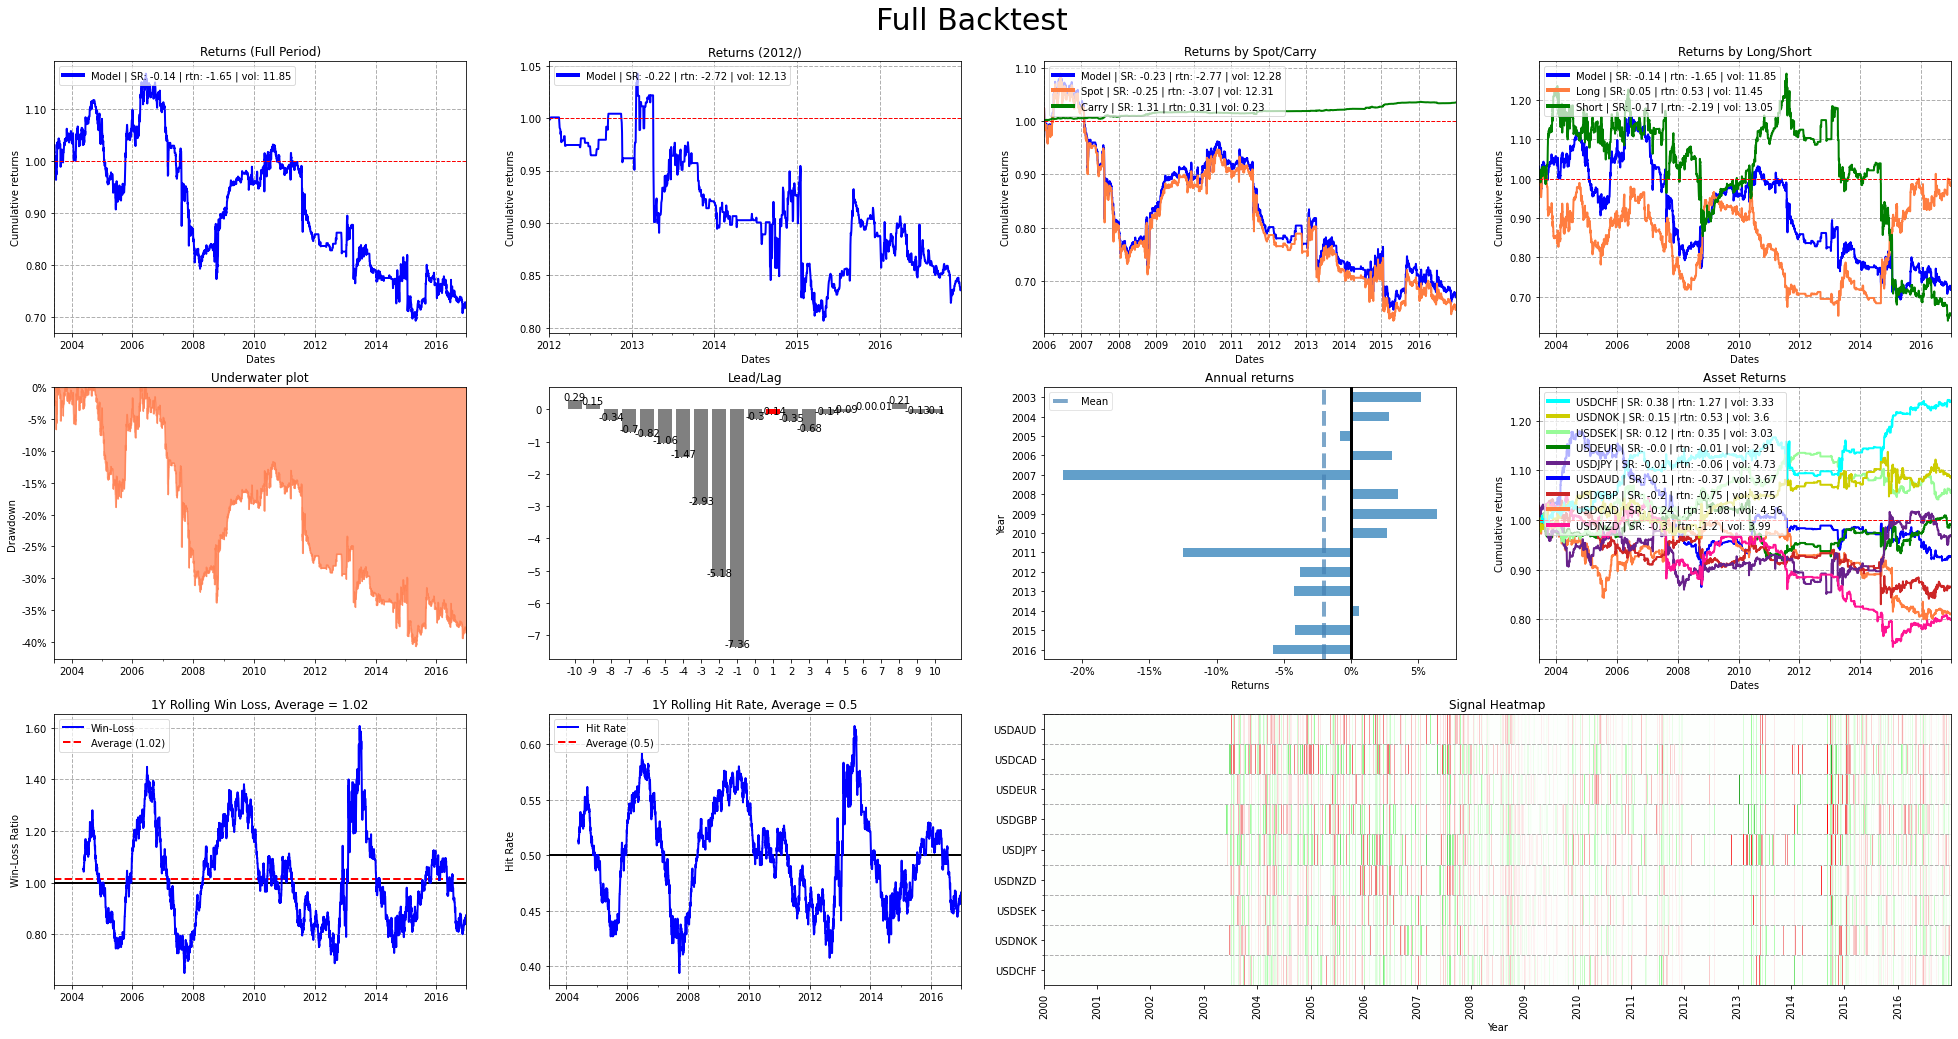

In [13]:
plot_bt(bt_obj)

# Lag 0

In [14]:
b = Backtest(signal = sig, asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = s, settings_inject={"implementation_lag":0})
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [15]:
bt_obj = b

In [16]:
get_summary(bt_obj)

Returns   : -0.03885459998737845
Vol       : 0.12970756114808651
SR        : -0.2995553971060973
Max DD    : -82.62
Hit rate  : 0.499
W | N | L : 0.32 | 0.37 | 0.32
W/L Ratio : 1.0


In [17]:
get_returns_stats(bt_obj.asset_rtn, b.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.095486,-0.805489,-0.58513,-1.430074,-1.263844,-1.112298,1.629243,-0.031673,0.398916
sharpe,0.02524,-0.188671,-0.198362,-0.322638,-0.250976,-0.262819,0.522672,-0.008409,0.113595
dollar_sharpe,0.006029,-0.202589,-0.206158,-0.340509,-0.282467,-0.284768,0.522767,-0.027597,0.091964
trade_sharpe,-0.390861,-1.157333,-0.478935,-0.94119,-1.042935,-0.91961,-0.1455,-0.637131,-0.002959
long_sharpe,0.22707,-1.873459,0.124055,-0.880198,-1.058632,-0.356215,0.260034,-0.316624,-0.032203
short_sharpe,-0.982703,-1.145143,-1.388237,-1.491865,-1.577321,-1.725795,-0.71473,-1.197859,0.033939
sortino,0.00821,-0.064123,-0.06725,-0.099418,-0.077912,-0.081448,0.193015,-0.002795,0.031678
max_drawdown,-18.89595,-18.757249,-18.997698,-40.232165,-29.950783,-31.744501,-4.312495,-18.165114,-22.557379
max_drawdown_start,2004-07-21,2003-09-02,2007-11-20,2004-03-08,2003-06-13,2004-03-10,2008-09-04,2006-03-30,2009-08-03
max_drawdown_end,2008-10-10,2016-12-16,2016-11-18,2016-06-20,2013-06-03,2015-08-26,2008-10-06,2015-03-17,2013-05-14


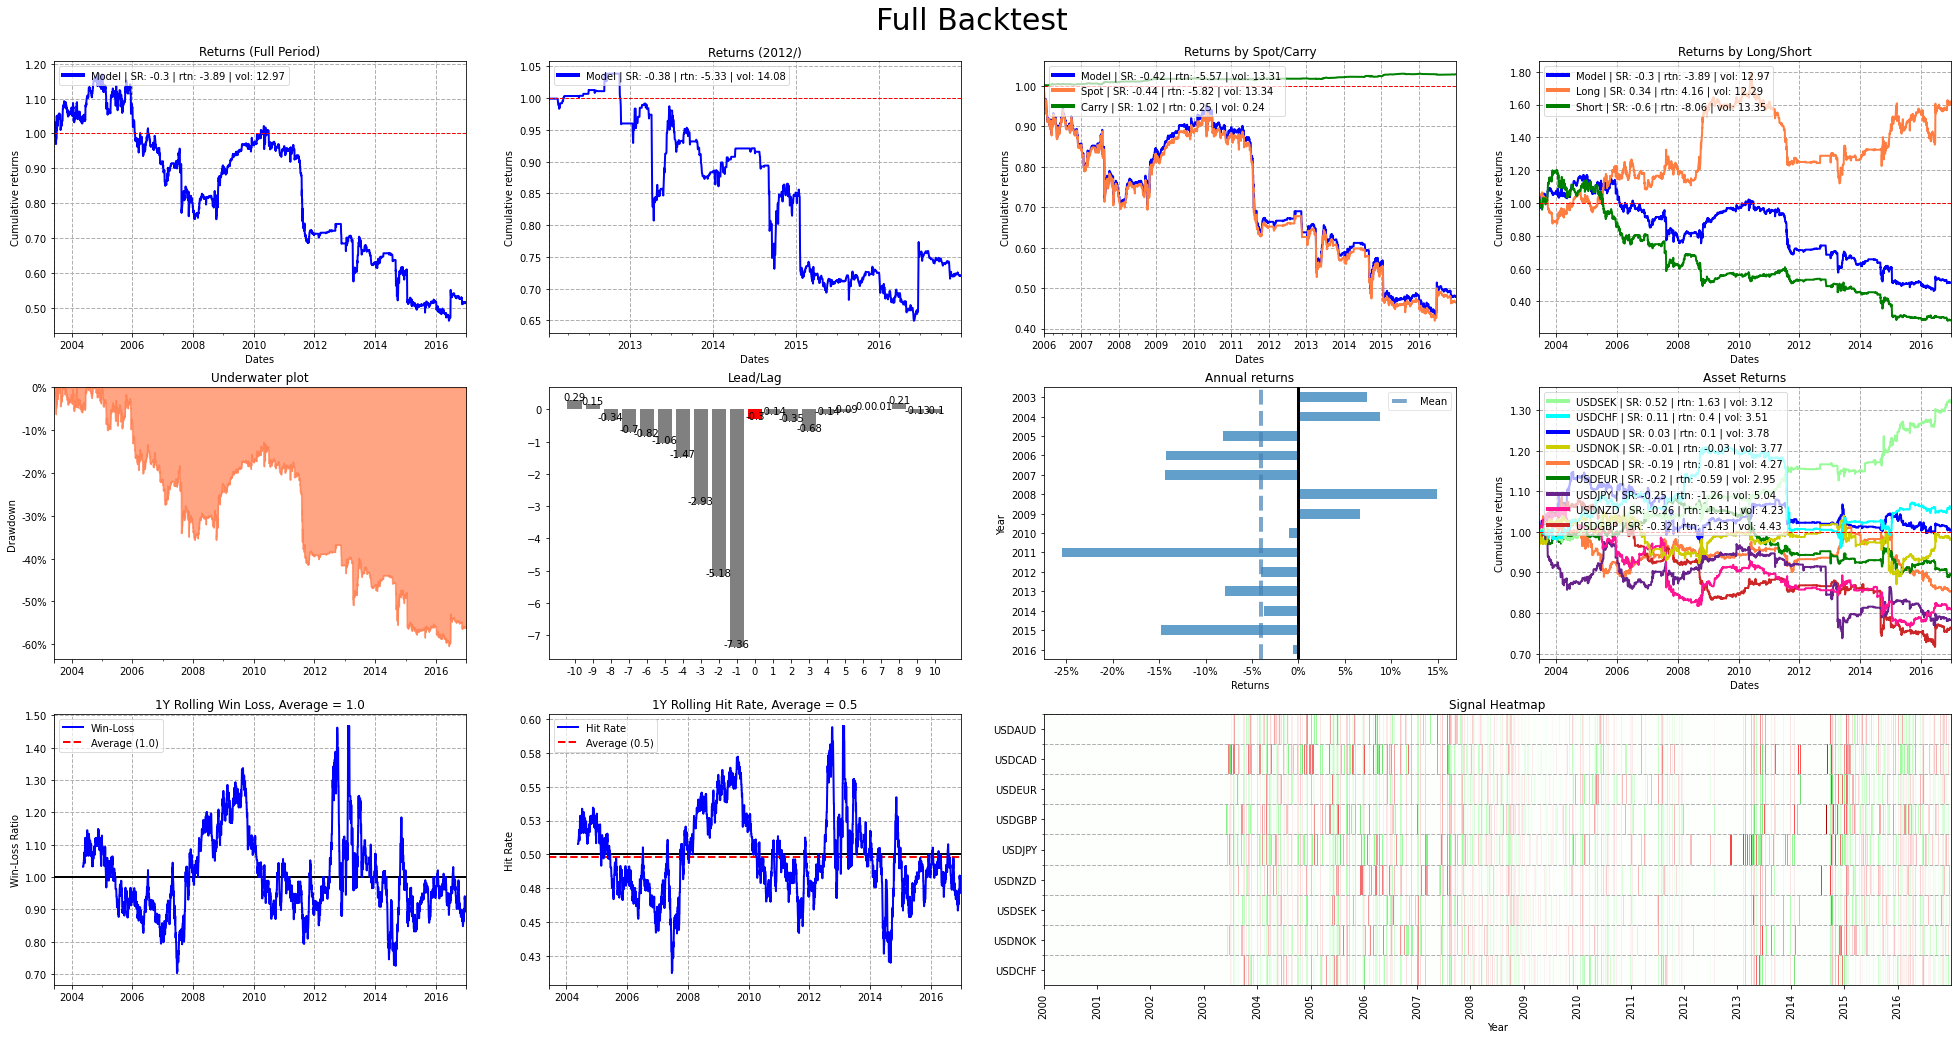

In [18]:
plot_bt(bt_obj)

In [ ]:
pf.plot_monthly_returns_dist(bt_objj.model_rtn)

In [ ]:
gs = GridSpec(nrows = 2, ncols = 2)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
fig.add_subplot(gs[1]).set_label(gen_rtn_asset(bt_obj))
fig.add_subplot(gs[2]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
fig.add_subplot(gs[3]).set_label(gen_rtn_longshort(bt_obj))

In [ ]:
# gen_rtn_longshort(bt_obj)
# gen_rtn_component(bt_obj, spot_rtns, carry_rtns)
# gen_leadlag(b, nlag=20)
# gen_rolling_hitrate(bt_obj.model_rtn)
# gen_rolling_winloss(bt_obj.model_rtn)
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)
# pf.plot_annual_returns(bt_obj.model_rtn)
# gen_signal(bt_obj)
# gen_rtn_asset(bt_obj)
# gen_plot_rtn(bt_obj.model_rtn["2012":])
# gen_rolling_sharpe(bt_obj.model_rtn)
# gen_rtn_col_component(bt_obj, spot_rtns, carry_rtns)
# gen_rtn_col_longshort(bt_obj)

In [ ]:
def band_filter(series):
  return series.applymap(lambda x: 1 if x < -1.5 else -1 if x > 1.5 else 0)

def hold_position(series):
  tmp = np.sign(series).diff()
  return pd.Series([np.nan if y == 0 else x for x,y in zip(series, tmp.diff())], index = tmp.index).ffill()

binary = spot_returns.pipe(zscore, 252*5).pipe(band_filter)
mag = abs(spot_returns.pipe(zscore, 252*5)) * binary
sig = mag.apply(hold_position)